<a href="https://colab.research.google.com/github/Aabir-Chakraborty/DL/blob/main/Copy_of_DL_lab6ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Q1. Analyze the use of tran_test_split class of Scikitlearn library and study the effects of different ratios of Training Data and Test data on the accuracy of a model.**

In [ ]:
#import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#import dataset
import seaborn as sns
iris = sns.load_dataset('iris')

In [ ]:
#convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

In [ ]:
#transform species to number
labels = torch.zeros(len(data), dtype = torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [ ]:
#create our fake dataset
fakedata = np.tile(np.array([1, 2, 3, 4]), (10, 1)) + np.tile(10 * np.arange(1, 11), (4, 1)).T
fakelabels = np.arange(10) > 4
print(fakedata), print(' ')
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


In [ ]:
#use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(fakedata, fakelabels, test_size = .2)

In [ ]:
#print out the sizes
print('Training the data size: ' + str(train_data.shape))
print('Test data size: ' + str(test_data.shape))
print(' ')

Training the data size: (8, 4)
Test data size: (2, 4)
 


In [ ]:
#print out the train/test data
print('Training data: ')
print(train_data)
print(' ')
print('Test data: ')
print(test_data)

Training data: 
[[ 11  12  13  14]
 [ 81  82  83  84]
 [101 102 103 104]
 [ 31  32  33  34]
 [ 71  72  73  74]
 [ 51  52  53  54]
 [ 91  92  93  94]
 [ 61  62  63  64]]
 
Test data: 
[[21 22 23 24]
 [41 42 43 44]]


In [ ]:
#a function that creates ANN model
def createANewModel():
  ANNiris = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 3)
  )
  #loss function
  lossfun = nn.CrossEntropyLoss()
  #optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr = .01) 
  return ANNiris, lossfun, optimizer

In [ ]:
#train the model
#global parameter
numepochs = 200
def trainTheModel(trainProp):
  #initialize losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []
  #loop over epochs
  for epochi in range(numepochs):
    #separate train from test data
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = trainProp)
    #forward pass and loss
    yHat = ANNiris(X_train)
    loss = lossfun(yHat, y_train)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #compute training accuracy
    trainAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y_train).float()).item())
    #test accuracy
    predlabels = torch.argmax(ANNiris(X_test), axis = 1)
    testAcc.append(100 * torch.mean((predlabels == y_test).float()).item())
    #function output
  return trainAcc, testAcc

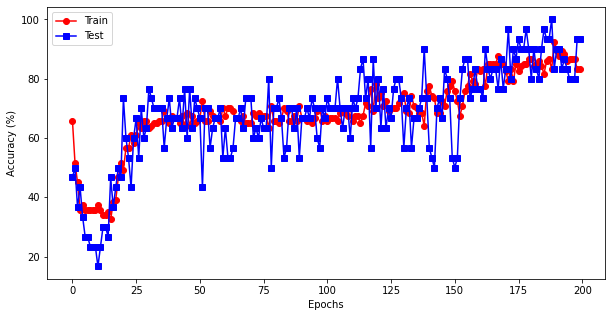

In [ ]:
#test the model
ANNiris, lossfun, optimizer = createANewModel()
#train the model
trainAcc, testAcc = trainTheModel(.8)
#plot the results
fig = plt.figure(figsize = (10, 5))
plt.plot(trainAcc, 'ro-')
plt.plot(testAcc, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.show()

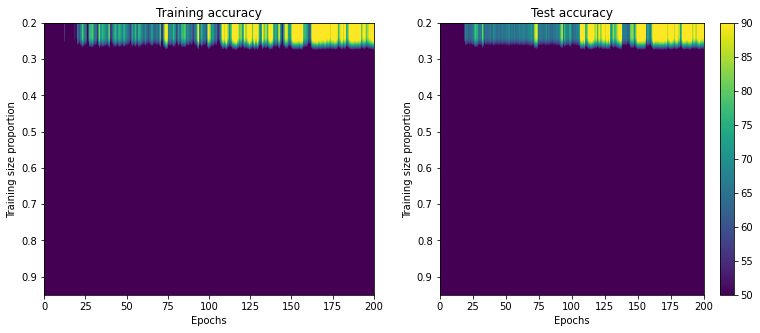

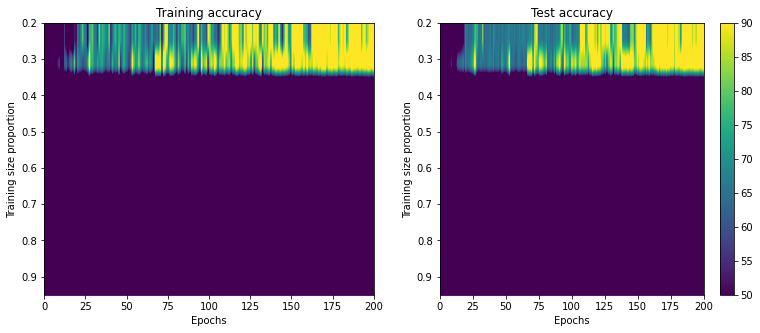

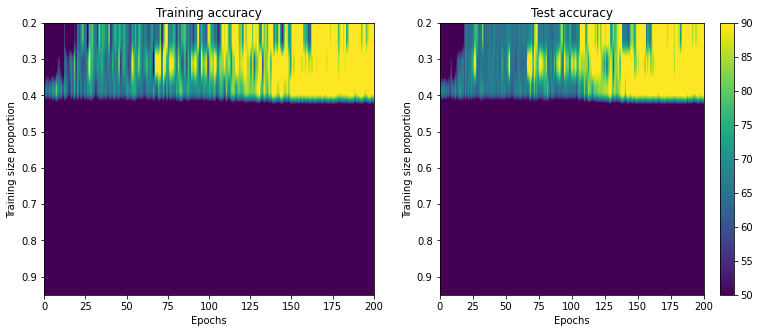

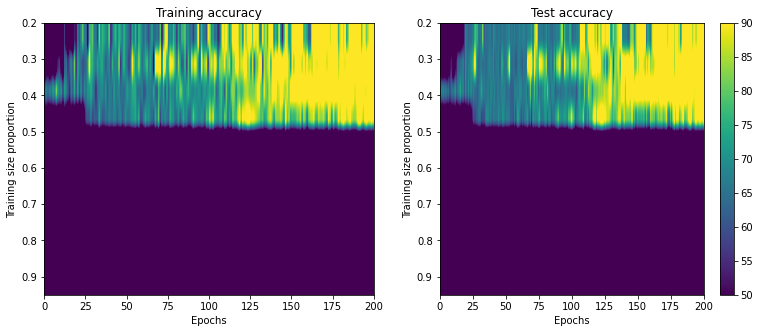

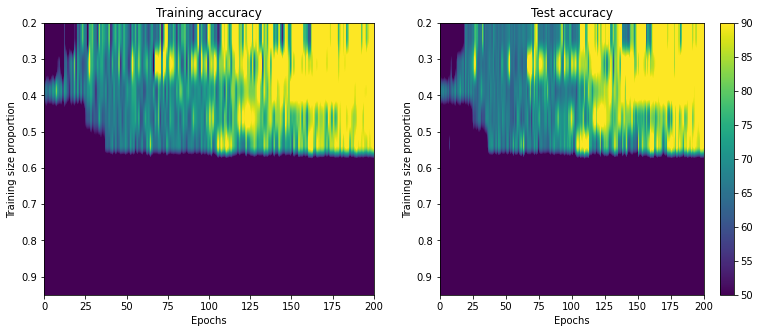

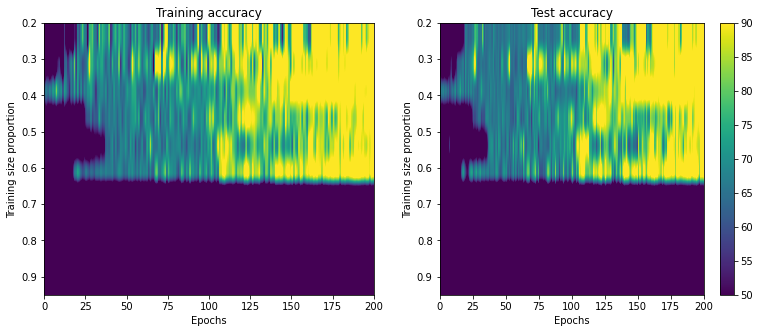

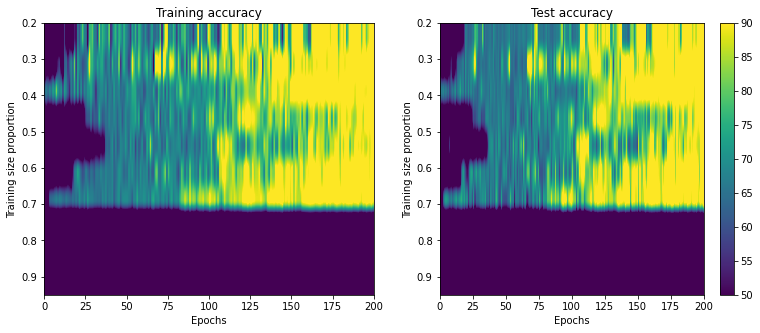

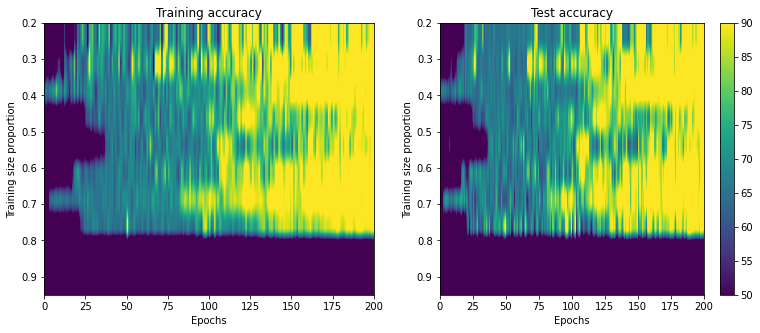

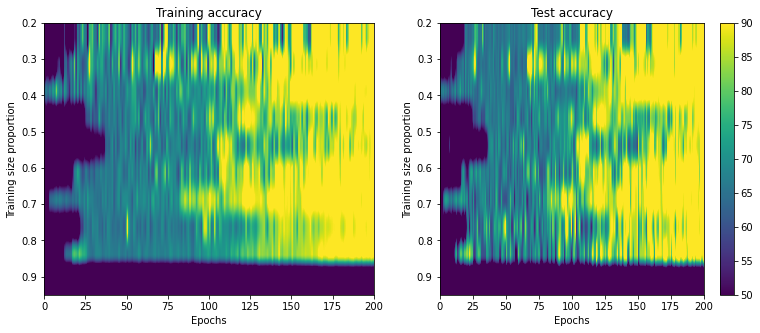

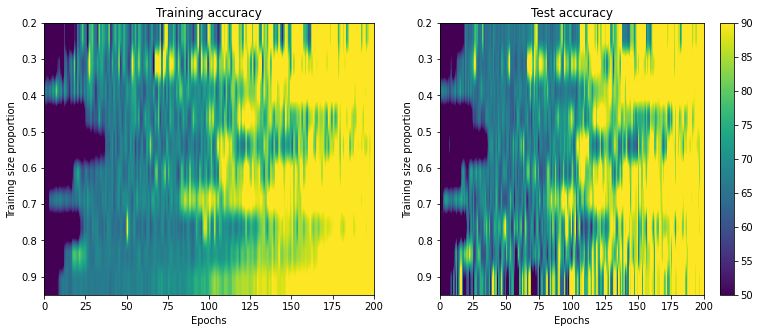

In [ ]:
trainSetSizes = np.linspace(.2, .95, 10)
allTrainAcc = np.zeros((len(trainSetSizes), numepochs))
allTestAcc = np.zeros((len(trainSetSizes), numepochs))
for i in range(len(trainSetSizes)):
  #create a model
  ANNiris, lossfun, optimizer = createANewModel()
  #train the model
  trainAcc, testAcc = trainTheModel(trainSetSizes[i])
  #store the results
  allTrainAcc[i, :] = trainAcc
  allTestAcc[i, :] = testAcc
  fig, ax = plt.subplots(1, 2, figsize = (13, 5))
  ax[0].imshow(allTrainAcc, aspect = 'auto', vmin = 50, vmax = 90, extent = [0, numepochs, trainSetSizes[-1], trainSetSizes[0]])
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Training size proportion')
  ax[0].set_title('Training accuracy')
  p = ax[1].imshow(allTestAcc, aspect = 'auto', vmin = 50, vmax = 90, extent = [0, numepochs, trainSetSizes[-1], trainSetSizes[0]])
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Training size proportion')
  ax[1].set_title('Test accuracy')
  fig.colorbar(p, ax = ax[1])
  plt.show()

**Q2. Develop an ANN model to analyze the implementation of Dropout as regularization.**

In [ ]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#create data
nPerClust = 200
th = np.linspace(0, 4 * np.pi, nPerClust)
r1 = 10
r2 = 15

In [ ]:
#generate data
a = [r1 * np.cos(th) + np.random.randn(nPerClust) * 3, r1 * np.sin(th) + np.random.randn(nPerClust)]
b = [r2 * np.cos(th) + np.random.randn(nPerClust) * 3, r2 * np.sin(th) + np.random.randn(nPerClust)]

In [ ]:
#true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

In [ ]:
#concatenate into a matrix
data_np = np.hstack((a, b)).T

In [ ]:
#convert into a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

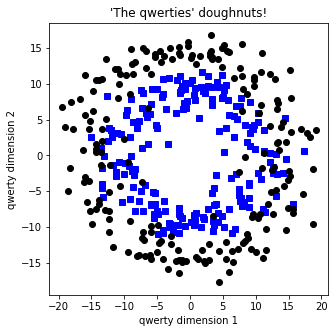

In [ ]:
#show the data
fig = plt.figure(figsize = (5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko')
plt.title("'The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [ ]:
#use skicit learn to split the data
train_data,test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [ ]:
#finally translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [ ]:
#create the model
class theModelClass(nn.Module):
  def __init__(self, dropoutRate):
    super().__init__()
    self.input = nn.Linear(2, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)
    #parameters
    self.dr = dropoutRate
  #forward pass
  def forward(self, x):
    #pass data through the input layer
    x = F.relu(self.input(x))
    #droput after input layer
    x  = F.dropout(x, p = self.dr, training = self.training)
    #pass the data through hidden layer
    x = F.relu(self.hidden(x))
    #dropout after the hidden layer
    x = F.dropout(x, p = self.dr, training = self.training)
    #output layer
    x = self.output(x)
    return x
  #test the model
tmpnet = theModelClass(.25)
  #run some random data through
tmpdata = torch.randn((10, 2))
yhat = tmpnet(tmpdata)
yhat

tensor([[0.1171],
        [0.2460],
        [0.2361],
        [0.1225],
        [0.1929],
        [0.3628],
        [0.2199],
        [0.2982],
        [0.3252],
        [0.2351]], grad_fn=<AddmmBackward0>)

In [ ]:
#functions to create and train the net
def createANewModel(dropoutrate):
  #grab an instance of the model class
  ANNQC = theModelClass(dropoutrate)
  #loss function
  lossfun = nn.BCEWithLogitsLoss()
  #optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(), lr = .002)
  return ANNQC, lossfun, optimizer

In [ ]:
#train the model
#training parameter
numepochs = 1000
def TrainTheModel(ANNQC, lossfun, optimizer):
  #initialize the accuracies as empties
  trainAcc = []
  testAcc = []
  #loop over epochs
  for epochi in range(numepochs):
    #switch trainning mode on
    ANNQC.train()
    #loop over training data batches
    batchAcc = []
    for X, y in train_loader:
      #forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat, y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #compute training accuracy just for this batch
      batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
    trainAcc.append(np.mean(batchAcc))
    #test accuracy
    ANNQC.eval()
    X, y = next(iter(test_loader))
    yHat = ANNQC(X)
    testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
  return trainAcc, testAcc

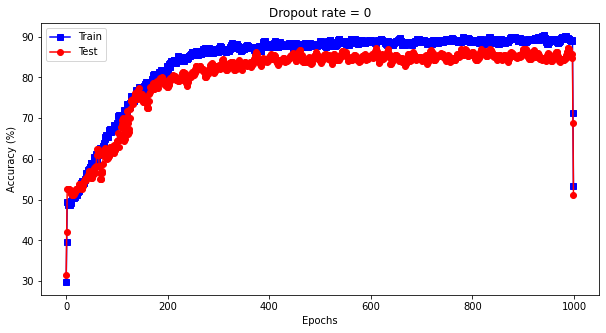

In [ ]:
#test the model
#create a model
dropoutrate = .0
ANNQC, lossfun, optimizer = createANewModel(dropoutrate)
#train the model
trainAcc, testAcc = TrainTheModel(ANNQC, lossfun, optimizer)
#create a 1d smoothening filter
def smooth(x, k = 5):
  return np.convolve(x, np.ones(k)/k, mode = 'same')
#plot the results
fig = plt.figure(figsize = (10, 5))
plt.plot(smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.title('Dropout rate = %g' %dropoutrate)
plt.show()

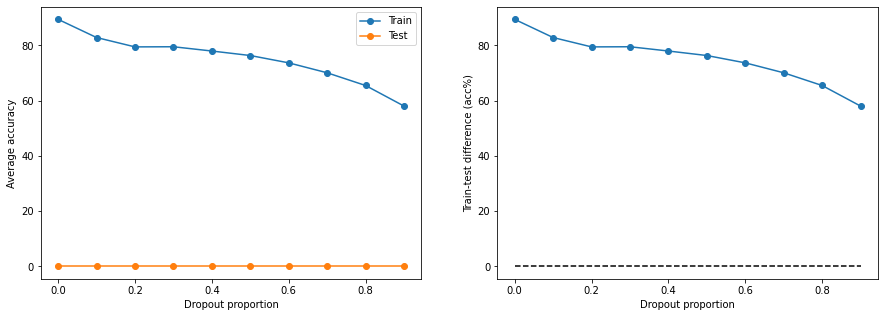

In [ ]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))
for di in range(len(dropoutRates)):
  #create the train model
  ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di])
  trainAcc, testAcc = TrainTheModel(ANNQC, lossfun, optimizer)
  #store accuracies from last 100 epochs
  results[di, 0] = np.mean(trainAcc[-100:])
#plot the experiment results
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])
ax[1].plot(dropoutRates, -np.diff(results, axis = 1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')
plt.show()